# Introduction to Semantic Segmentation with Deep Learning

This notebook introduces **semantic segmentation**, a fundamental task in computer vision where we classify each pixel of an image into a category.

## What is Segmentation?

Unlike **classification** (one label per image) or **object detection** (bounding boxes), **segmentation** produces a pixel-wise mask:

| Task | Output | Example |
|------|--------|---------|
| Classification | Single label | "This is a brain scan" |
| Detection | Bounding boxes | Rectangle around tumor |
| **Segmentation** | Pixel mask | Exact tumor boundary |

### Types of Segmentation:
- **Semantic Segmentation**: Classify every pixel (all tumors = same class)
- **Instance Segmentation**: Distinguish individual objects (tumor 1, tumor 2, ...)
- **Panoptic Segmentation**: Combines both approaches

## Application: Brain Tumor Segmentation

In this notebook, we'll build a **U-Net** model to segment brain tumors from MRI scans. This is a binary segmentation task:
- **Class 0 (background)**: Normal brain tissue
- **Class 1 (foreground)**: Tumor region

---

## Setup and Dependencies

In [ ]:
%pip install torch torchvision pycocotools tqdm matplotlib numpy

### Download the Dataset

We download a brain tumor MRI dataset from Kaggle in COCO format. The COCO format stores annotations (including segmentation masks) in a JSON file.

In [ ]:
!mkdir -p ./data
!unzip -q data.zip -d ./data

In [ ]:
import os

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.datasets import CocoDetection
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset

from pycocotools.coco import COCO


from tqdm import tqdm
import random
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    print(f"Model size: {size_all_mb:.2f} MB")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == "cpu":
    device = torch.device('mps') if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device
print(f'Using device: {device}')

Using device: cuda


### Import Libraries

Key libraries:
- **PyTorch** - Deep learning framework
- **pycocotools** - Parse COCO-format annotations and extract segmentation masks
- **torchvision.transforms.v2** - Image preprocessing and augmentation

---

## Dataset Preparation

### Understanding COCO Format

The **COCO (Common Objects in Context)** format stores annotations separately from images:
- **Images**: Stored as regular image files (PNG, JPG)
- **Annotations**: JSON file containing:
  - Image metadata (size, filename)
  - Segmentation masks (as polygons or RLE encoding)
  - Category information

This format is memory-efficient since masks are stored as compact polygons rather than full images.

In [ ]:
train_dir = "./data/train/"
val_dir = "./data/valid/"
test_dir = "./data/test/"

train_annotation_file = "./data/train/_annotations.coco.json"
val_annotation_file = "./data/valid/_annotations.coco.json"
test_annotation_file = "./data/test/_annotations.coco.json"


### Visualize Data with Masks

Let's visualize some brain MRI images alongside their tumor segmentation masks. We use the COCO API to:
1. Load image metadata
2. Find all annotations (tumor regions) for that image
3. Convert polygon annotations to binary masks using `annToMask()`

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


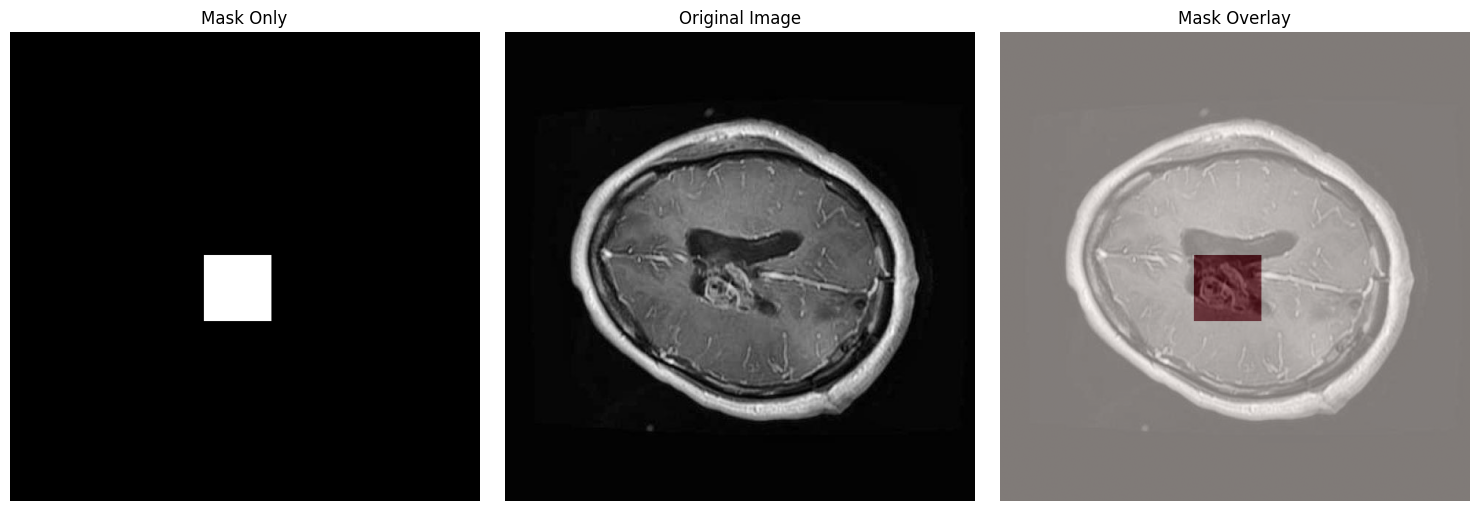

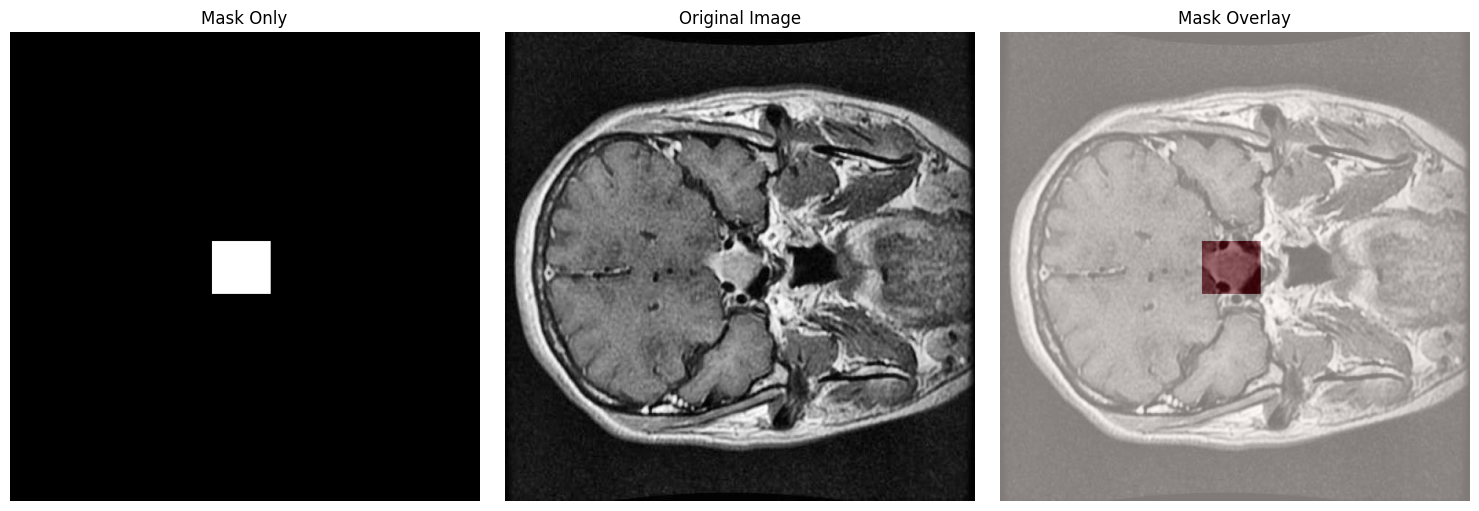

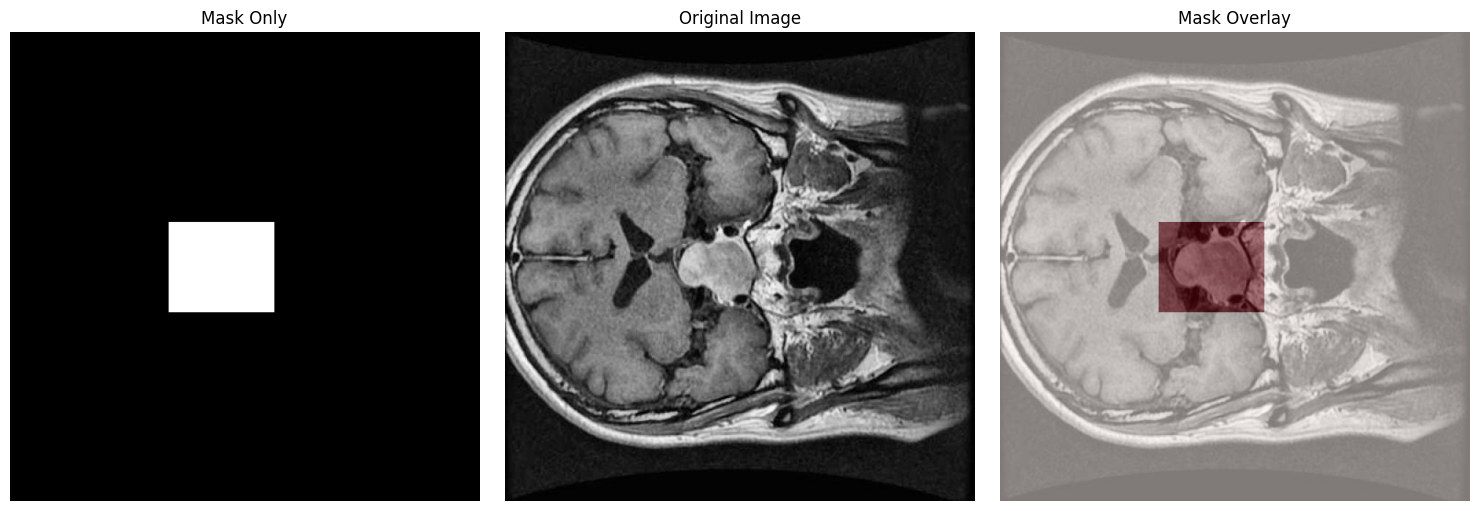

In [ ]:
# Visualize mask overlay on brain images
# bit difficult on this part because the mask is in the metadata of the image
# so I had to use COCO to extract it

coco = COCO(train_annotation_file)

image_ids = random.sample(coco.getImgIds(), 3)

for i, image_id in enumerate(image_ids):

    image_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(train_dir, image_info['file_name'])

    image = Image.open(img_path)

    mask = np.zeros((image_info['height'], image_info['width']))

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    plt.figure(figsize=(15, 5))

    # Mask
    plt.subplot(1, 3, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask Only')
    plt.axis('off')

    # Original image
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5, cmap='Reds')
    plt.title('Mask Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### Custom PyTorch Dataset

We create a custom `Dataset` class that:
1. Loads images from disk
2. Extracts segmentation masks from COCO annotations
3. Applies separate transforms to images and masks

**Important**: Image and mask transforms must be compatible (same resize, same crop region). Here we use simple resizing to 256×256 for both.

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, annotation_file, image_transform=None, mask_transform=None):

        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = self.coco.getImgIds()
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):

        # Coco image info
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]

        img_path = os.path.join(self.image_dir, image_info['file_name'])

        image = Image.open(img_path)

        mask = np.zeros((image_info['height'], image_info['width']))
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        mask = (mask > 0).astype(np.uint8) * 255

        mask = Image.fromarray(mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

            mask = (mask > 0.5).float()

        return image, mask

### Create DataLoaders

We set up three data splits:
- **Training set**: Model learns from this data
- **Validation set**: Monitor performance during training (hyperparameter tuning)
- **Test set**: Final evaluation on completely unseen data

In [ ]:
# Setup dataset and data loader


image_transform = v2.Compose([v2.Resize((256, 256)), v2.ToImage(), v2.ToDtype(torch.float32)])

mask_transform = v2.Compose([v2.Resize((256, 256)), v2.ToImage(), v2.ToDtype(torch.float32)])

train_dataset = BrainTumorDataset(train_dir, train_annotation_file,
                                  image_transform=image_transform,
                                  mask_transform=mask_transform)

val_dataset   = BrainTumorDataset(val_dir, val_annotation_file,
                                  image_transform=image_transform,
                                  mask_transform=mask_transform)

test_dataset  = BrainTumorDataset(test_dir, test_annotation_file,
                                  image_transform=image_transform,
                                  mask_transform=mask_transform)

train_loader = DataLoader (train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader (val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader (test_dataset, batch_size=16, shuffle=False)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


---

## Segmentation Metrics

Evaluating segmentation models requires specialized metrics that account for pixel-wise predictions:

### 1. Dice Score (F1 Score for Segmentation)

$$\text{Dice} = \frac{2 \times |P \cap T|}{|P| + |T|}$$

- Measures overlap between prediction ($P$) and ground truth ($T$)
- Range: 0 (no overlap) to 1 (perfect match)
- Commonly used in medical imaging

### 2. Intersection over Union (IoU / Jaccard Index)

$$\text{IoU} = \frac{|P \cap T|}{|P \cup T|}$$

- More strict than Dice (penalizes false positives/negatives more)
- Standard metric for segmentation benchmarks

### 3. Pixel Accuracy

$$\text{Accuracy} = \frac{\text{Correct Pixels}}{\text{Total Pixels}}$$

- Simple but can be misleading with class imbalance
- If 95% of pixels are background, predicting "all background" gives 95% accuracy!

**Note**: Dice and IoU are more informative for imbalanced datasets (common in medical imaging where lesions are small).

In [ ]:
def dice_score(pred, target, threshold=0.5, epsilon=1e-7):
    pred = (pred > threshold).float()
    inter = (pred * target).sum()
    return (2 * inter + epsilon) / (pred.sum() + target.sum() + epsilon)

def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    pred = (pred > threshold).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + epsilon) / (union + epsilon)

def pixel_accuracy(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = target.float()
    correct = (pred == target).float().sum()
    total = target.numel()
    return correct / total

---

## U-Net Architecture

**U-Net** is the most influential architecture for semantic segmentation, introduced in 2015 for biomedical image segmentation.

### Key Design Principles

```
Input Image (256×256×3)                                                             
        │                                                                           
        ▼                                                                           
                                                                                    
     ENCODER                        DECODER                                         
(Contracting Path)            (Decontracting Path)                                  
   ┌─────────┐                    ┌─────────┐                                       
   │ Conv 64 │   SKIP CONNECTION  │UpConv 64│                                       
   │ MaxPool │───────────────────▶│  +skip  │ ───────▶ Output Mask (256×256×1)      
   └────┬────┘                    └────┬────┘                                       
        │                              │                                            
   ┌────┴────┐                    ┌────┴────┐                                       
   │ Conv 128│   SKIP CONNECTION  │UpConv128│                                       
   │ MaxPool │───────────────────▶│  +skip  │                                       
   └────┬────┘                    └────┬────┘                                       
        │                              │                                            
   ┌────┴────┐                    ┌────┴────┐                                       
   │ Conv 256│   SKIP CONNECTION  │UpConv256│                                       
   │ MaxPool │───────────────────▶│  +skip  │                                       
   └────┬────┘                    └────┬────┘                                       
        │                              │                                            
   ┌────┴────┐                    ┌────┴────┐                                       
   │ Conv 512│   SKIP CONNECTION  │UpConv512│                                       
   │ MaxPool │───────────────────▶│ +skip   │                                       
   └────┬────┘                    └────┬────┘                                       
        │                              │                                            
        │        ┌─────────────┐       │                                            
        └───────▶│  Bottleneck │───────┘                                            
                 │  Conv 1024  │                                                    
                 └─────────────┘                                                    
        (1024 channels, smallest spatial size)                                      
                                                                                    
```

### Why U-Net Works So Well

1. **Encoder-Decoder Structure**:
   - **Encoder**: Extracts hierarchical features (edges → textures → objects)
   - **Decoder**: Recovers spatial resolution for pixel-wise prediction

2. **Skip Connections** (The "U" shape):
   - Connect encoder layers directly to decoder layers
   - Preserve fine-grained spatial details lost during downsampling
   - Critical for accurate boundary delineation

3. **Symmetric Design**:
   - Same number of layers in encoder and decoder
   - Gradual upsampling matches gradual downsampling

### Building Blocks

The U-Net implementation consists of:

- **DoubleConv**: Two consecutive Conv → BatchNorm → ReLU blocks (basic feature extraction unit)
- **DownBlock**: MaxPool followed by DoubleConv (encoder block)
- **UpBlock**: Transposed convolution (upsampling) + skip connection concatenation + DoubleConv
- **Bottleneck**: Deepest layer connecting encoder to decoder

In [ ]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.inc = DoubleConv(in_channels, features[0])
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Down blocks
        for i in range(len(features) - 1):
            self.downs.append(DownBlock(features[i], features[i+1]))

        # Bottleneck
        self.bottleneck = DownBlock(features[-1], features[-1]*2)

        # Up blocks
        for feature in reversed(features):
            self.ups.append(UpBlock(feature*2, feature))

        self.outc = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        skips = [x1]

        x = x1
        for down in self.downs:
            x = down(x)
            skips.append(x)

        x = self.bottleneck(skips[-1])
        skips = skips[::-1]

        for i, up in enumerate(self.ups):
            x = up(x, skips[i])

        return self.outc(x)

def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    print(f"Model size: {size_all_mb:.2f} MB")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
model = Unet(features=[8, 16, 32, 64]).to(device)
assert model(torch.randn(4,3,256,256, device=device)).shape == (4,1,256,256)
print_model_size(model)

Model size: 1.86 MB
Number of parameters: 487289


### Instantiate the Model

We use a smaller U-Net with `features=[8, 16, 32, 64]` instead of the original `[64, 128, 256, 512]` to:
- Speed up training on limited hardware
- Reduce memory usage
- The brain tumor dataset is relatively simple (binary segmentation)

---

## Training the Model

### Loss Function: Binary Cross-Entropy with Logits

For binary segmentation, we use **BCEWithLogitsLoss**:

$$L = -\frac{1}{N}\sum_{i=1}^{N} \left[ y_i \cdot \log(\sigma(x_i)) + (1-y_i) \cdot \log(1-\sigma(x_i)) \right]$$

Where:
- $x_i$ is the model output (logit) for pixel $i$
- $y_i$ is the ground truth (0 or 1)
- $\sigma$ is the sigmoid function

**Why BCEWithLogitsLoss?**
- Combines sigmoid activation + BCE loss in one numerically stable operation
- Model outputs raw logits (no sigmoid in final layer)
- Apply sigmoid only for inference/metrics

### Optimizer: Adam

Adam (Adaptive Moment Estimation) adapts learning rates per parameter, typically converging faster than SGD for segmentation tasks.

In [ ]:
epochs = 15
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []
val_pixel_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        optim.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optim.step()

        epoch_train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_dice = 0
    epoch_iou = 0
    epoch_acc = 0

    with torch.no_grad():
        loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        for images, masks in loop_val:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_val_loss += loss.item()

            # Apply sigmoid for metrics since model outputs logits
            preds = torch.sigmoid(outputs)

            epoch_dice += dice_score(preds, masks).item()
            epoch_iou += iou_score(preds, masks).item()
            epoch_acc += pixel_accuracy(preds, masks).item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_dice = epoch_dice / len(val_loader)
    avg_iou = epoch_iou / len(val_loader)
    avg_acc = epoch_acc / len(val_loader)

    val_losses.append(avg_val_loss)
    val_dice_scores.append(avg_dice)
    val_iou_scores.append(avg_iou)
    val_pixel_accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

Epoch 1/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.59it/s]


Epoch 1: Train Loss: 0.5717, Val Loss: 0.5287, Dice: 0.0000, IoU: 0.0000


Epoch 2/15 [Val]: 100%|██████████| 27/27 [00:05<00:00,  4.88it/s]


Epoch 2: Train Loss: 0.4595, Val Loss: 0.4362, Dice: 0.0000, IoU: 0.0000


Epoch 3/15 [Val]: 100%|██████████| 27/27 [00:05<00:00,  5.28it/s]


Epoch 3: Train Loss: 0.3545, Val Loss: 0.2677, Dice: 0.0000, IoU: 0.0000


Epoch 4/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.60it/s]


Epoch 4: Train Loss: 0.2478, Val Loss: 0.2761, Dice: 0.0000, IoU: 0.0000


Epoch 5/15 [Val]: 100%|██████████| 27/27 [00:05<00:00,  5.14it/s]


Epoch 5: Train Loss: 0.1809, Val Loss: 0.1842, Dice: 0.2658, IoU: 0.1552


Epoch 6/15 [Val]: 100%|██████████| 27/27 [00:05<00:00,  4.94it/s]


Epoch 6: Train Loss: 0.1412, Val Loss: 0.1532, Dice: 0.5090, IoU: 0.3439


Epoch 7/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.64it/s]


Epoch 7: Train Loss: 0.1158, Val Loss: 0.1121, Dice: 0.3416, IoU: 0.2111


Epoch 8/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.63it/s]


Epoch 8: Train Loss: 0.1011, Val Loss: 0.1252, Dice: 0.0433, IoU: 0.0225


Epoch 9/15 [Val]: 100%|██████████| 27/27 [00:05<00:00,  4.95it/s]


Epoch 9: Train Loss: 0.0900, Val Loss: 0.0928, Dice: 0.3931, IoU: 0.2491


Epoch 10/15 [Val]: 100%|██████████| 27/27 [00:05<00:00,  5.09it/s]


Epoch 10: Train Loss: 0.0813, Val Loss: 0.1325, Dice: 0.5829, IoU: 0.4134


Epoch 11/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.63it/s]


Epoch 11: Train Loss: 0.0744, Val Loss: 0.0803, Dice: 0.6214, IoU: 0.4544


Epoch 12/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.57it/s]


Epoch 12: Train Loss: 0.0692, Val Loss: 0.0897, Dice: 0.6207, IoU: 0.4523


Epoch 13/15 [Val]: 100%|██████████| 27/27 [00:05<00:00,  4.95it/s]


Epoch 13: Train Loss: 0.0642, Val Loss: 0.0771, Dice: 0.6110, IoU: 0.4424


Epoch 14/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.64it/s]


Epoch 14: Train Loss: 0.0619, Val Loss: 0.0982, Dice: 0.3307, IoU: 0.2041


Epoch 15/15 [Val]: 100%|██████████| 27/27 [00:04<00:00,  5.69it/s]

Epoch 15: Train Loss: 0.0588, Val Loss: 0.0724, Dice: 0.5436, IoU: 0.3783


### Training Curves

Visualize training progress:
- **Loss curves**: Should decrease for both train and validation
- **Metrics**: Dice, IoU, and Pixel Accuracy should increase
- Watch for overfitting: validation metrics stop improving while training metrics continue

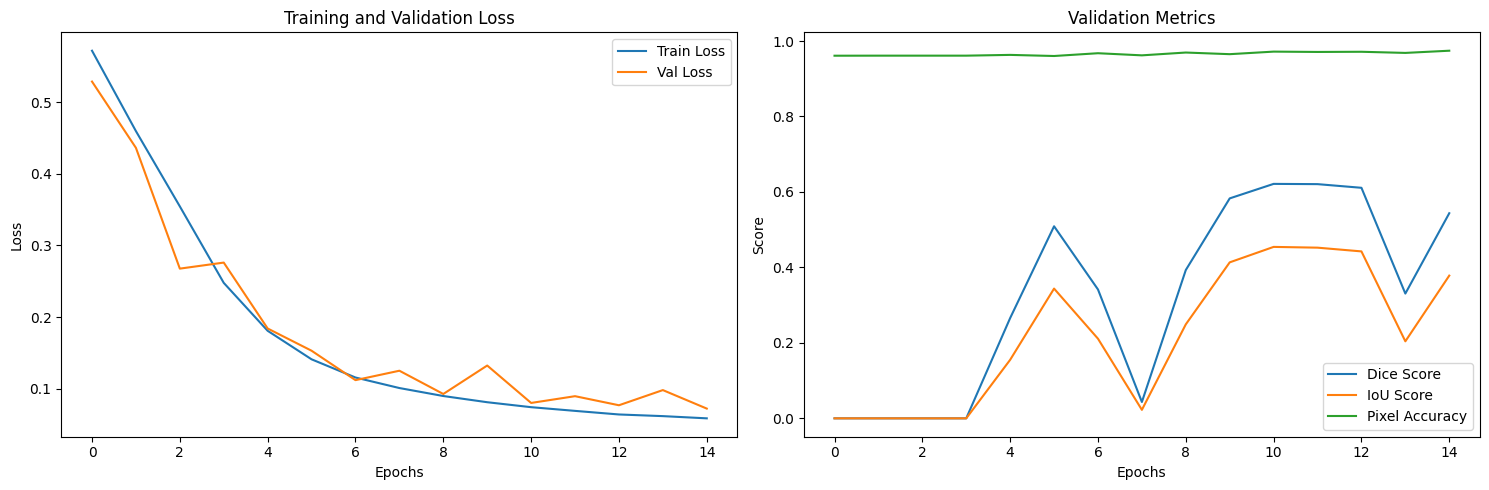

In [ ]:
# Plotting
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Metrics
plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label='Dice Score')
plt.plot(val_iou_scores, label='IoU Score')
plt.plot(val_pixel_accuracies, label='Pixel Accuracy')
plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

---

## Evaluation on Test Set

Final evaluation on held-out test data gives an unbiased estimate of model performance. We report:
- **Test Loss**: How well the model's predictions match ground truth
- **Dice Score**: Overlap quality (most important for medical imaging)
- **IoU Score**: Stricter overlap metric
- **Pixel Accuracy**: Simple correctness measure

In [ ]:
# Test Loop
model.eval()
test_loss = 0
test_dice = 0
test_iou = 0
test_acc = 0

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for images, masks in loop_test:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.sigmoid(outputs)

        test_dice += dice_score(preds, masks).item()
        test_iou += iou_score(preds, masks).item()
        test_acc += pixel_accuracy(preds, masks).item()

avg_test_loss = test_loss / len(test_loader)
avg_test_dice = test_dice / len(test_loader)
avg_test_iou = test_iou / len(test_loader)
avg_test_acc = test_acc / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Dice: {avg_test_dice:.4f}")
print(f"Test IoU: {avg_test_iou:.4f}")
print(f"Test Acc: {avg_test_acc:.4f}")

Testing: 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

Test Loss: 0.4892
Test Dice: 0.0022
Test IoU: 0.0011
Test Acc: 0.9590


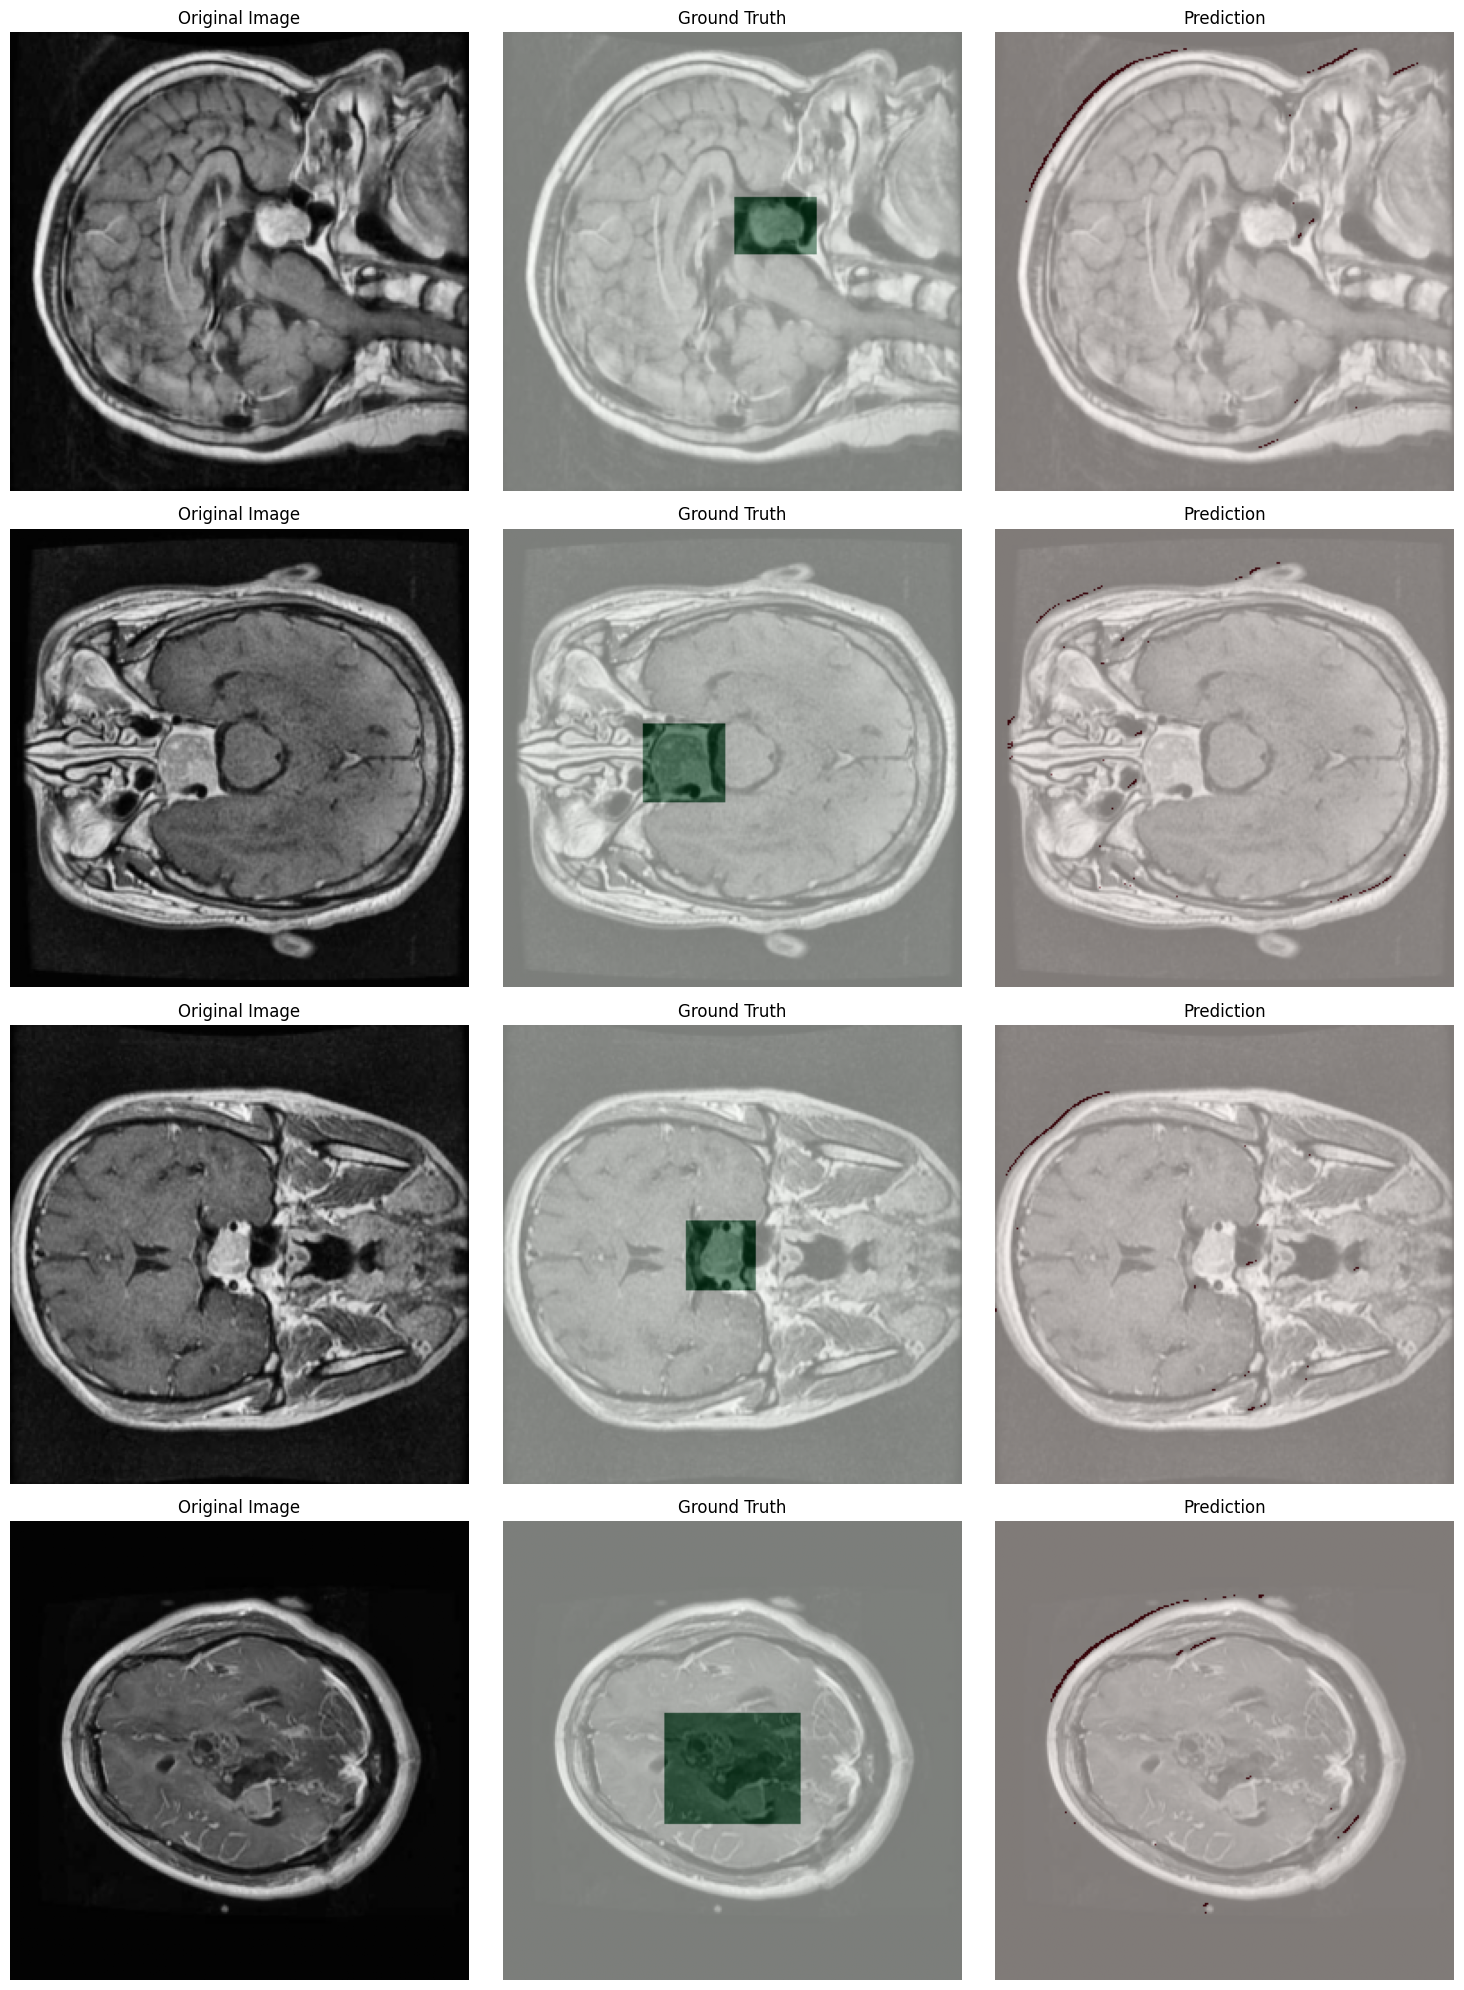

In [ ]:
# Visualization
model.eval()
images, masks = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()

# Move to cpu for plotting
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

num_images = min(4, images.size(0))

plt.figure(figsize=(15, 5 * num_images))

for i in range(num_images):
    img = images[i].permute(1, 2, 0).numpy()

    # Normalize image for display if needed
    if img.max() > 1.0:
        img = img / 255.0

    mask = masks[i].squeeze().numpy()
    pred = preds[i].squeeze().numpy()

    # Original Image
    plt.subplot(num_images, 3, i*3 + 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Ground Truth
    plt.subplot(num_images, 3, i*3 + 2)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='Greens')
    plt.title('Ground Truth')
    plt.axis('off')

    # Prediction
    plt.subplot(num_images, 3, i*3 + 3)
    plt.imshow(img)
    plt.imshow(pred, alpha=0.5, cmap='Reds')
    plt.title('Prediction')
    plt.axis('off')

plt.tight_layout()
plt.show()

---

## Summary

### What We Learned

| Concept | Description |
|---------|-------------|
| **Semantic Segmentation** | Pixel-wise classification of images |
| **U-Net Architecture** | Encoder-decoder with skip connections |
| **Skip Connections** | Preserve spatial details for accurate boundaries |
| **Dice / IoU** | Overlap metrics for segmentation evaluation |
| **BCEWithLogitsLoss** | Stable loss for binary segmentation |

### U-Net Key Takeaways

1. **Encoder** captures "what" is in the image (semantic features)
2. **Decoder** recovers "where" things are (spatial resolution)
3. **Skip connections** combine both for precise localization
4. Works exceptionally well with **limited training data** (common in medical imaging)

### Potential Improvements

- **Data Augmentation**: Random flips, rotations, elastic deformations
- **Dice Loss**: Directly optimize the Dice score instead of BCE
- **Deeper Models**: More encoder/decoder blocks for complex patterns
- **Attention Mechanisms**: Focus on relevant image regions (Attention U-Net)
- **Pre-trained Encoders**: Use ImageNet-trained backbones (ResNet, EfficientNet)

### Other Segmentation Architectures

| Architecture | Key Innovation |
|--------------|----------------|
| **FCN** (2014) | First fully convolutional approach |
| **U-Net** (2015) | Skip connections for medical imaging |
| **DeepLab** (2016) | Atrous/dilated convolutions, CRF post-processing |
| **PSPNet** (2017) | Pyramid pooling for multi-scale context |
| **Mask R-CNN** (2017) | Instance segmentation (detection + segmentation) |
| **SegFormer** (2021) | Transformer-based encoder |

# Part 2: Segmentation with data augmentation

## Why Data Augmentation for Segmentation?

Data augmentation is a regularization technique that artificially increases the size of the training set by applying random transformations to the input data. This helps:

1. **Reduce overfitting**: The model sees more variations of the data
2. **Improve generalization**: The model learns to be invariant to certain transformations
3. **Handle limited data**: Especially important in medical imaging where labeled data is scarce

### Critical Difference: Segmentation vs Classification

In **classification**, we only augment the image because the label (e.g., "cat") remains the same regardless of transformations.

In **segmentation**, **we MUST apply the same spatial transformations to both the image AND the mask**!

| Augmentation Type | Apply to Image | Apply to Mask |
|-------------------|----------------|---------------|
| **Spatial** (flip, rotate, crop) | ✅ Yes | ✅ Yes (same transform!) |
| **Color/Intensity** (brightness, contrast) | ✅ Yes | ❌ No |
| **Noise** (Gaussian noise) | ✅ Yes | ❌ No |

### Example: Why Synchronized Transforms Matter

```
Original:          After Horizontal Flip:
                   
Image: [tumor→]    Image: [←tumor]
Mask:  [████  ]    Mask:  [  ████]  ← Must flip too!

If mask not flipped:
Image: [←tumor]    
Mask:  [████  ]    ← WRONG! Tumor location mismatch!
```

### Implementing Synchronized Augmentation

To apply the same random transformation to both image and mask, we have several options:

1. **Use the same random seed** for both transforms
2. **Stack image and mask** before transforming, then split
3. **Use `torchvision.transforms.v2`** which supports joint transforms on multiple inputs

We'll use a custom approach where we manually apply the same transformation to both the image and mask within our Dataset class.

In [ ]:
class BrainTumorDatasetAugmented(Dataset):
    """
    Dataset with synchronized augmentation for segmentation.

    Key insight: Spatial augmentations (flip, rotate, etc.) must be applied
    identically to both the image and its corresponding mask.
    """
    def __init__(self, image_dir, annotation_file, augment=False):

        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = self.coco.getImgIds()
        self.augment = augment

        # Base transforms (always applied)
        self.base_transform = v2.Compose([
            v2.Resize((256, 256)),
            v2.ToImage(),
            v2.ToDtype(torch.float32)
        ])

    def __len__(self):
        return len(self.image_ids)

    def apply_augmentation(self, image, mask):
        """
        Apply synchronized augmentations to both image and mask.

        TODO: Complete this method to apply the following augmentations:
        1. Random Horizontal Flip (50% probability)
        2. Random Vertical Flip (50% probability)
        3. Random Rotation (up to 30 degrees)

        HINT: Use random.random() to decide whether to apply each augmentation,
        then use the same transformation function on both image and mask.

        Available functions from torchvision.transforms.v2.functional:
        - v2.functional.horizontal_flip(tensor)
        - v2.functional.vertical_flip(tensor)
        - v2.functional.rotate(tensor, angle)
        """

        # ============== YOUR CODE HERE ==============
        # 1. Random Horizontal Flip (50% probability)


        # 2. Random Vertical Flip (50% probability)


        # 3. Random Rotation (between -30 and 30 degrees)


        # ============================================

        return image, mask

    def __getitem__(self, idx):

        # Load image
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(img_path)

        # Create mask from COCO annotations
        mask = np.zeros((image_info['height'], image_info['width']))
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        mask = (mask > 0).astype(np.uint8) * 255
        mask = Image.fromarray(mask)

        # Apply base transforms
        image = self.base_transform(image)
        mask = self.base_transform(mask)
        mask = (mask > 0.5).float()

        # Apply augmentation (only during training)
        if self.augment:
            image, mask = self.apply_augmentation(image, mask)

        return image, mask

### Visualize Augmented Samples

Let's visualize the effect of our augmentations on both the image and the mask. Notice how the transformations are perfectly synchronized!

In [ ]:
# Visualize augmented samples
# Create dataset with augmentation enabled
augmented_dataset = BrainTumorDatasetAugmented(train_dir, train_annotation_file, augment=True)

# Get the same image multiple times to see different augmentations
sample_idx = 0

plt.figure(figsize=(15, 10))

for i in range(6):
    image, mask = augmented_dataset[sample_idx]

    # Convert to numpy for plotting
    img = image.permute(1, 2, 0).numpy()
    if img.max() > 1.0:
        img = img / 255.0
    msk = mask.squeeze().numpy()

    plt.subplot(3, 4, i*2 + 1)
    plt.imshow(img)
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

    plt.subplot(3, 4, i*2 + 2)
    plt.imshow(img)
    plt.imshow(msk, alpha=0.5, cmap='Reds')
    plt.title(f'With Mask Overlay {i+1}')
    plt.axis('off')

plt.suptitle('Same image with different random augmentations\n(Notice how mask transformations match the image!)', fontsize=14)
plt.tight_layout()
plt.show()

### Create DataLoaders with Augmentation

Now let's create our data loaders. Remember:
- **Training set**: Apply augmentation (`augment=True`)
- **Validation/Test sets**: NO augmentation (`augment=False`) - we want to evaluate on clean data

In [ ]:
# ============== YOUR CODE HERE ==============
# TODO: Create datasets using BrainTumorDatasetAugmented
# Remember: augment=True for training, augment=False for validation/test

train_dataset_aug = BrainTumorDatasetAugmented(
    ___,
    ___,
    augment=___  # TODO: Should training data be augmented?
)

val_dataset_aug = BrainTumorDatasetAugmented(
    ___,
    ___,
    augment=___  # TODO: Should validation data be augmented?
)

test_dataset_aug = BrainTumorDatasetAugmented(
    ___,
    ___,
    augment=___  # TODO: Should test data be augmented?
)
# ============================================

# Create DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=16, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset_aug)}")
print(f"Validation samples: {len(val_dataset_aug)}")
print(f"Test samples: {len(test_dataset_aug)}")

---

## Training with Data Augmentation

Now let's train a new U-Net model with our augmented dataset.

**Your task:** Complete the training loop below. You can use the training loop from Part 1 as reference, but you need to fill in the key steps yourself.

**Reminder of the training loop structure:**
1. **Training phase**: Set model to train mode, iterate over batches, compute loss, backpropagate
2. **Validation phase**: Set model to eval mode, disable gradients, compute metrics

**Key functions you'll need:**
- `model.train()` / `model.eval()` - switch between training and evaluation modes
- `optimizer.zero_grad()` - clear gradients before backpropagation
- `loss.backward()` - compute gradients
- `optimizer.step()` - update weights
- `torch.no_grad()` - context manager to disable gradient computation
- `torch.sigmoid()` - convert logits to probabilities for metrics

### Prédiction avant l'entraînement

**Avant d'exécuter l'entraînement**, répondez à cette question :

**Q0 : Selon vous, l'augmentation de données va-t-elle améliorer ou dégrader les performances du modèle par rapport à la Partie 1 ? Justifiez votre prédiction.**

*Votre prédiction :*

---

*Rappel de vos résultats Partie 1 (reportez vos valeurs ici) :*
- Dice Score (test) Partie 1 : `___`
- IoU Score (test) Partie 1 : `___`

---

In [ ]:
# Initialize a new model for training with augmentation (Set up the UNET with the features sizes you want)
model_aug = Unet(features=[_]).to(device)
print_model_size(model_aug)

In [ ]:
# Training loop with augmented data
# ============== SETUP (provided) ==============
epochs_aug = 15
optim_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-3)
criterion_aug = nn.BCEWithLogitsLoss()

train_losses_aug = []
val_losses_aug = []
val_dice_scores_aug = []
val_iou_scores_aug = []
val_pixel_accuracies_aug = []

for epoch in range(epochs_aug):

    # ============== TRAINING PHASE ==============
    # TODO: Set the model to training mode


    epoch_train_loss = 0

    loop = tqdm(train_loader_aug, desc=f"Epoch {epoch+1}/{epochs_aug} [Train]")
    for images, masks in loop:
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # TODO: Complete the training step
        # Step 1: Zero the gradients


        # Step 2: Forward pass - get model predictions
        outputs =

        # Step 3: Compute the loss
        loss =

        # Step 4: Backward pass - compute gradients


        # Step 5: Update weights


        epoch_train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader_aug)
    train_losses_aug.append(avg_train_loss)

    # ============== VALIDATION PHASE ==============
    # TODO: Set the model to evaluation mode
    ___

    epoch_val_loss = 0
    epoch_dice = 0
    epoch_iou = 0
    epoch_acc = 0

    # TODO: Use the correct context manager to disable gradient computation
    with ___:
        loop_val = tqdm(val_loader_aug, desc=f"Epoch {epoch+1}/{epochs_aug} [Val]")
        for images, masks in loop_val:
            images = images.to(device)
            masks = masks.to(device)

            # TODO: Forward pass (no backprop needed)
            outputs = ___
            loss = ___
            epoch_val_loss += loss.item()

            # TODO: Convert logits to probabilities for metrics
            # HINT: The model outputs raw logits, but metrics expect probabilities


            # Compute metrics (provided)
            epoch_dice += dice_score(preds, masks).item()
            epoch_iou += iou_score(preds, masks).item()
            epoch_acc += pixel_accuracy(preds, masks).item()

    # Compute averages and store (provided)
    avg_val_loss = epoch_val_loss / len(val_loader_aug)
    avg_dice = epoch_dice / len(val_loader_aug)
    avg_iou = epoch_iou / len(val_loader_aug)
    avg_acc = epoch_acc / len(val_loader_aug)

    val_losses_aug.append(avg_val_loss)
    val_dice_scores_aug.append(avg_dice)
    val_iou_scores_aug.append(avg_iou)
    val_pixel_accuracies_aug.append(avg_acc)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

### Compare Training Curves: With vs Without Augmentation

Let's compare the training dynamics of both models side by side.

In [ ]:
# Compare training curves
plt.figure(figsize=(18, 5))

# Loss comparison
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train (No Aug)', linestyle='--', alpha=0.7)
plt.plot(val_losses, label='Val (No Aug)', linestyle='--', alpha=0.7)
plt.plot(train_losses_aug, label='Train (With Aug)', linewidth=2)
plt.plot(val_losses_aug, label='Val (With Aug)', linewidth=2)
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Dice Score comparison
plt.subplot(1, 3, 2)
plt.plot(val_dice_scores, label='No Augmentation', linestyle='--', alpha=0.7)
plt.plot(val_dice_scores_aug, label='With Augmentation', linewidth=2)
plt.title('Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True, alpha=0.3)

# IoU comparison
plt.subplot(1, 3, 3)
plt.plot(val_iou_scores, label='No Augmentation', linestyle='--', alpha=0.7)
plt.plot(val_iou_scores_aug, label='With Augmentation', linewidth=2)
plt.title('Validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle('Training Comparison: With vs Without Data Augmentation', fontsize=14)
plt.tight_layout()
plt.show()

---

## Final Evaluation: Test Set Comparison

Let's evaluate both models on the test set and compare their performance.

In [ ]:
# Test the augmented model
model_aug.eval()
test_loss_aug = 0
test_dice_aug = 0
test_iou_aug = 0
test_acc_aug = 0

with torch.no_grad():
    loop_test = tqdm(test_loader_aug, desc="Testing (Augmented Model)")
    for images, masks in loop_test:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_aug(images)
        loss = criterion_aug(outputs, masks)
        test_loss_aug += loss.item()

        preds = torch.sigmoid(outputs)

        test_dice_aug += dice_score(preds, masks).item()
        test_iou_aug += iou_score(preds, masks).item()
        test_acc_aug += pixel_accuracy(preds, masks).item()

avg_test_loss_aug = test_loss_aug / len(test_loader_aug)
avg_test_dice_aug = test_dice_aug / len(test_loader_aug)
avg_test_iou_aug = test_iou_aug / len(test_loader_aug)
avg_test_acc_aug = test_acc_aug / len(test_loader_aug)

# Print comparison
print("=" * 60)
print("TEST SET RESULTS COMPARISON")
print("=" * 60)
print(f"{'Metric':<20} {'No Augmentation':<20} {'With Augmentation':<20}")
print("-" * 60)
print(f"{'Loss':<20} {avg_test_loss:.4f}{'':<16} {avg_test_loss_aug:.4f}")
print(f"{'Dice Score':<20} {avg_test_dice:.4f}{'':<16} {avg_test_dice_aug:.4f}")
print(f"{'IoU Score':<20} {avg_test_iou:.4f}{'':<16} {avg_test_iou_aug:.4f}")
print(f"{'Pixel Accuracy':<20} {avg_test_acc:.4f}{'':<16} {avg_test_acc_aug:.4f}")
print("=" * 60)

### Visual Comparison of Predictions

Let's visualize predictions from both models on the same test images.

In [ ]:
# Visual comparison
model.eval()
model_aug.eval()

images, masks = next(iter(test_loader_aug))
images = images.to(device)

with torch.no_grad():
    # Predictions from model without augmentation
    outputs_no_aug = model(images)
    preds_no_aug = torch.sigmoid(outputs_no_aug)
    preds_no_aug = (preds_no_aug > 0.5).float()

    # Predictions from model with augmentation
    outputs_aug = model_aug(images)
    preds_aug = torch.sigmoid(outputs_aug)
    preds_aug = (preds_aug > 0.5).float()

# Move to cpu for plotting
images = images.cpu()
masks = masks.cpu()
preds_no_aug = preds_no_aug.cpu()
preds_aug = preds_aug.cpu()

num_images = min(4, images.size(0))

plt.figure(figsize=(20, 5 * num_images))

for i in range(num_images):
    img = images[i].permute(1, 2, 0).numpy()
    if img.max() > 1.0:
        img = img / 255.0

    mask = masks[i].squeeze().numpy()
    pred_no = preds_no_aug[i].squeeze().numpy()
    pred_aug = preds_aug[i].squeeze().numpy()

    # Original Image
    plt.subplot(num_images, 4, i*4 + 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Ground Truth
    plt.subplot(num_images, 4, i*4 + 2)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='Greens')
    plt.title('Ground Truth')
    plt.axis('off')

    # Prediction WITHOUT augmentation
    plt.subplot(num_images, 4, i*4 + 3)
    plt.imshow(img)
    plt.imshow(pred_no, alpha=0.5, cmap='Blues')
    plt.title('Pred (No Aug)')
    plt.axis('off')

    # Prediction WITH augmentation
    plt.subplot(num_images, 4, i*4 + 4)
    plt.imshow(img)
    plt.imshow(pred_aug, alpha=0.5, cmap='Reds')
    plt.title('Pred (With Aug)')
    plt.axis('off')

plt.suptitle('Comparison: Ground Truth vs Predictions (No Aug vs With Aug)', fontsize=14)
plt.tight_layout()
plt.show()

---

## Questions de Réflexion

Répondez aux questions suivantes en vous basant sur **vos résultats spécifiques** :

---

**Q1 : Reportez vos métriques finales sur le jeu de test :**

| Métrique | Sans Augmentation (Partie 1) | Avec Augmentation (Partie 2) | Différence |
|----------|------------------------------|------------------------------|------------|
| Dice Score | `___` | `___` | `___` |
| IoU Score | `___` | `___` | `___` |
| Pixel Accuracy | `___` | `___` | `___` |
| Loss | `___` | `___` | `___` |

---

**Q2 : Votre prédiction (Q0) était-elle correcte ? Expliquez pourquoi l'augmentation a eu cet effet sur vos résultats.**

*Votre réponse :*

---

**Q3 : Pourquoi est-il essentiel d'appliquer la même transformation géométrique à la fois à l'image et au masque dans les tâches de segmentation ?**

*Votre réponse :*

---

**Q4 : Quels types d'augmentations ne doivent PAS être appliqués au masque ? Donnez 3 exemples et expliquez pourquoi.**

*Votre réponse :*

---

**Q5 : Observez vos courbes d'entraînement (Loss et Dice). Décrivez les différences entre les deux modèles. Le modèle avec augmentation converge-t-il plus vite ou plus lentement ? Pourquoi ?**

*Votre réponse :*

---

**Q6 : Si votre objectif était d'entrainer le meilleur modèle possible sur ce dataset, quelles améliorations proposeriez vous ? et pourquoi ? (modèle, augmentations, pipeline...)**

*Votre réponse :*

---

**Q7 (Bonus) : On utiliser actuellement une Loss BCE (Binary Cross Entropy) pour entrainer le Unet. Cependant notre modèle ne détecte pas bien les bords des objets. Proposer une modification de la Loss pour résoudre ce problème.**

*Votre réponse :*

---